In [1]:
%pip install mediapipe opencv-python numpy pandas
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
cap = cv2.VideoCapture('smash_video_example.mp4')

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/50.9 MB ? eta -:--:--
   - -------------------------------------- 2.1/50.9 MB 14.7 MB/s eta 0:00:04
   ---- ----------------------------------- 5.8/50.9 MB 16.8 MB/s eta 0:00:03
   -------- ------------------------------- 10.5/50.9 MB 18.7 MB/s eta 0:00:03
   ----------- ---------------------------- 14.2/50.9 MB 18.2 MB/s eta 0:00:03
   -------------- ------------------------- 18.4/50.9 MB 18.4 MB/s eta 0:00:02
   ----------------- ---------------------- 22.8/50.9 MB 19.0 MB/s eta 0:00:02
   --------------------- ------------------ 27.3/50.9 MB 19.2 MB/s eta 0:00:02
   ------------------------ --------------- 31.5/50.9 MB 19.4 MB/s eta 

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
cap = cv2.VideoCapture('smash_video_example.mp4')

keypoints_data = []
frame_count = 0

# Define the keypoint indices you want (11-16 for shoulders, elbows, wrists)
KEYPOINT_INDICES = range(0, 25)  # 11, 12, 13, 14, 15, 16

while cap.isOpened():
    ret, frame = cap.read() 
    if not ret:
        break
    
    # Convert the frame to RGB (MediaPipe requires RGB)
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    
    if results.pose_landmarks:
        # Extract only the specified keypoints
        landmarks = results.pose_landmarks.landmark
        keypoints = []
        for idx in KEYPOINT_INDICES:
            lm = landmarks[idx]
            keypoints.extend([lm.x, lm.y])  # store x, y only
        
        keypoints_data.append([frame_count] + keypoints)
        
        # Optional: draw skeleton on video
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    
    cv2.imshow('Pose Detection', frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
        break
    
    frame_count += 1

cap.release()
cv2.destroyAllWindows()

In [49]:
columns = ['frame_count'] + [f'kpt_{i}_{axis}' for i in KEYPOINT_INDICES for axis in ['x', 'y']]

df_user = pd.DataFrame(keypoints_data, columns=columns)
df_user.insert(0, 'id', 'user_video')
df_user.insert(1, 'type_of_shot', 'smash')
print(df_user.head())

           id type_of_shot  frame_count   kpt_0_x   kpt_0_y   kpt_1_x  \
0  user_video        smash           21  0.527657  0.485089  0.525761   
1  user_video        smash           22  0.527588  0.485315  0.526068   
2  user_video        smash           23  0.525673  0.485198  0.524588   
3  user_video        smash           24  0.526235  0.485182  0.525034   
4  user_video        smash           25  0.527214  0.488486  0.526619   

    kpt_1_y   kpt_2_x   kpt_2_y   kpt_3_x  ...  kpt_12_x  kpt_12_y  kpt_13_x  \
0  0.482594  0.525792  0.482729  0.525837  ...  0.522793  0.522813  0.526527   
1  0.482149  0.526347  0.482103  0.526840  ...  0.522095  0.522841  0.527557   
2  0.482151  0.524585  0.482161  0.524611  ...  0.522939  0.518441  0.525389   
3  0.481874  0.524790  0.477228  0.524640  ...  0.524083  0.524515  0.513495   
4  0.485197  0.526734  0.484206  0.526866  ...  0.521340  0.524364  0.524223   

   kpt_13_y  kpt_14_x  kpt_14_y  kpt_15_x  kpt_15_y  kpt_16_x  kpt_16_y  
0  0.5

In [50]:
# Save the filtered keypoints DataFrame to CSV
csv_filename = 'user_keypoints_5_12.csv'
df_user.to_csv(csv_filename, index=False)
print(f"Saved keypoints to {csv_filename}")

Saved keypoints to user_keypoints_5_12.csv


AttributeError: 'NoneType' object has no attribute 'annotate'

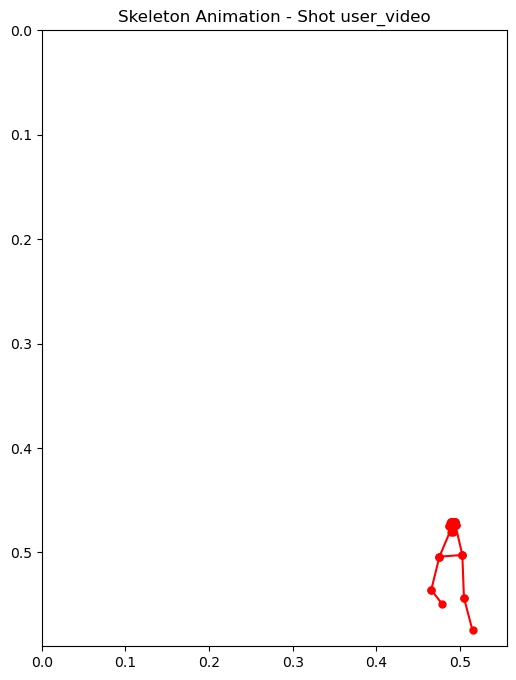

In [ ]:
df = pd.read_csv('user_keypoints_5_12.csv')

# Removing type_of_shot (they're all the same)
df = df.drop('type_of_shot', axis = 1)

df.head()

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Choose which shot id to visualize

shot_id = 'user_video'

shot_df = df[df['id'] == shot_id].reset_index(drop=True)

# Skeleton connections (COCO style)
skeleton = [
    (0,1),(0,2),(1,3),(2,4),
    (0,5),(0,6),(5,7),(7,9),(6,8),(8,10),
    (5,11),(6,12),(11,12),(11,13),(13,15),
    (12,14),(14,16)
]

# Set up the plot
fig, ax = plt.subplots(figsize=(6,8))
lines = []
for _ in skeleton:
    line, = ax.plot([], [], 'ro-', markersize=5)
    lines.append(line)

ax.set_xlim(0, df[[f'kpt_{i}_x' for i in range(17)]].max().max())
ax.set_ylim(0, df[[f'kpt_{i}_y' for i in range(17)]].max().max())
ax.invert_yaxis()
ax.set_title(f"Skeleton Animation - Shot {shot_id}")

# Animation function
def update(frame):
    row = shot_df.iloc[frame]
    keypoints = [(row[f'kpt_{i}_x'], row[f'kpt_{i}_y']) for i in range(17)]

    for idx, (a,b) in enumerate(skeleton):
        if keypoints[a][0] != 0 and keypoints[a][1] != 0 and keypoints[b][0] != 0 and keypoints[b][1] != 0:
            lines[idx].set_data([keypoints[a][0], keypoints[b][0]],
                                [keypoints[a][1], keypoints[b][1]])
        else:
            lines[idx].set_data([], [])
    return lines

# Create animation
anim = FuncAnimation(fig, update, frames=len(shot_df), interval=200, blit=True)

# plt.show()

# Save animation 
anim.save(f'badminton_shot_{shot_id}.gif', writer='pillow')
